In [ ]:
!pip install opencv-python
!pip install cmake
!pip install dlib

## 1. 이미지 준비하기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

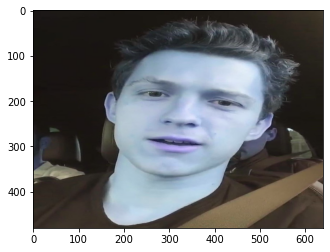

In [2]:
# 이미지 읽기
import os

my_image_path = os.getenv('HOME')+'/aiffel/Exploration/E3/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

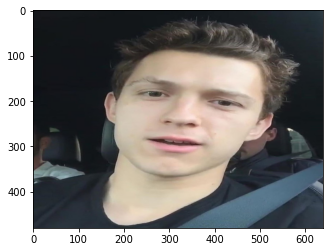

In [3]:
# opencv가 사용하는 BGR --> 원래 색상 RGB로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 face detection

In [4]:
# dlib을 활용해 hog detector를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   

In [5]:
# detector를 이용해서 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (rgb image, num of img pyramid)

- detector_hog의 첫 번째 파라미터는 rgb 이미지입니다.
- 두 번째 파라미터는 이미지 피라미드의 수입니다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다. 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

rectangles[[(170, 99) (491, 420)]]


- dlib detector 는 dlib.rectangles 타입의 객체를 반환합니다.
- dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어져 있습니다.
- dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있습니다. 

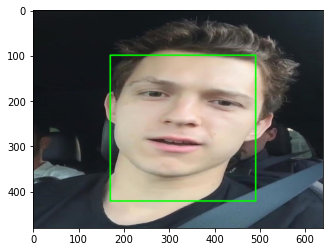

In [7]:
# 찾은 얼굴을 화면에 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 얼굴 랜드마크 face landmark

In [8]:
# 저장한 landmark 모델을 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/Exploration/E3/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [9]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


- landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력받아 dlib.full_object_detection를 반환합니다.
- points는 dlib.full_object_detection의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. (x, y) 형태로 접근할 수 있도록 변환해 주었습니다.
- list_points는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.
   
\* dlib.full_object_detection
http://dlib.net/python/index.html#dlib.full_object_detection

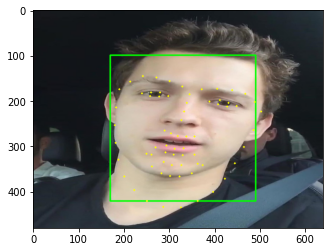

In [10]:
# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용하기

In [11]:
# 좌표를 먼저 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(327, 242)
(x,y) : (327,81)
(w,h) : (322,322)


In [12]:
# 준비해 둔 스티커 이미지를 읽어서 적용해 보기
import os
sticker_path = os.getenv('HOME')+'/aiffel/Exploration/E3/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(322, 322, 3)


- 왕관 이미지를 읽고 윗 단계에서 계산한 크기(w,h)로 resize


In [13]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정
# 이미지 시작점은 top-left 좌표
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (166,-241)


- 출력해보면 문제가 생기는 것을 확인할 수 있습니다. y축 좌표의 값이 음수가 계산 되었습니다.
    음수는 스티커가 이미지 밖을 넘었다는 것입니다. 이미지 범위 밖 스티커 값을 제거해야 합니다.

In [14]:
# -y 크기만큼 스티커를 crop 
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(81, 322, 3)


- opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다. 
- 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 합니다.

In [15]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (166,0)


- top 의 y 좌표는 원본 이미지의 경계 값으로 수정합니다.

In [16]:
# 원본 이미지에 스티커를 적용
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

- sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.     
    예제에서는 (166,0) 부터 (166+322, 0+81) 범위의 이미지를 의미합니다.
- 스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다.     
    따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다. img_show 에 다시 적용하겠습니다.

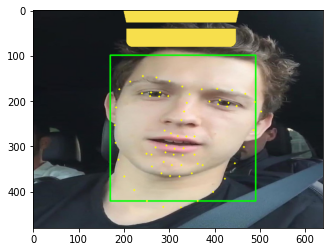

In [17]:
# 결과 이미지를 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

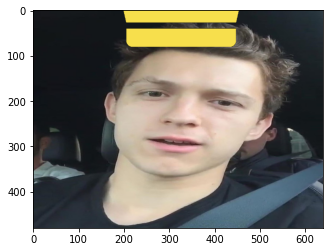

In [18]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()